In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import math
import time
import random
import subprocess
import tempfile

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
from tqdm import tqdm

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import AdaLead
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [4]:
#----------------------- HPO model -----------------------
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()

Loaded model from 20211113_021200 in eval mode


archive unpacked in ./


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [25]:
# pickle_paths = ['gs://syrgoth/boda_library_design_202112/pickles/sg__k562__fsp__track_001__round_5__20211207_170244__856014.pt',
#                'gs://syrgoth/boda_library_design_202112/extra_pickles/rc__k562__fsp__track_001__round_0__20211211_151901__803624.pt']

# pickle_paths = ['gs://syrgoth/boda_library_design_202112/pickles/sg__hepg2__fsp__track_001__round_5__20211207_194303__533151.pt',
#                'gs://syrgoth/boda_library_design_202112/extra_pickles/rc__hepg2__fsp__track_002__round_0__20211211_154135__149600.pt']

pickle_paths = ['gs://syrgoth/boda_library_design_202112/pickles/sg__sknsh__fsp__track_001__round_5__20211207_214224__766389.pt',
               'gs://syrgoth/boda_library_design_202112/extra_pickles/rc__sknsh__fsp__track_003__round_0__20211211_160357__747372.pt']

In [26]:
proposal_dicts = {}
for file_name in tqdm(pickle_paths):
    with tempfile.TemporaryDirectory() as tmpdir:
        temp_loc = os.path.join(tmpdir, os.path.basename(file_name)) 
        subprocess.check_call(['gsutil', 'cp', file_name, temp_loc])
        proposal_dicts[os.path.basename(file_name).rstrip('.pt')] = torch.load(temp_loc)

100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


In [27]:
proposal_dicts.keys()

dict_keys(['sg__sknsh__fsp__track_001__round_5__20211207_214224__766389', 'rc__sknsh__fsp__track_003__round_0__20211211_160357__747372'])

In [28]:
sg_seqs = list(proposal_dicts.values())[0]['proposals'][0]['proposals']
rc_seqs = list(proposal_dicts.values())[1]['proposals'][0]['proposals']

In [29]:
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200]).unsqueeze(0) 

sg_pieces = [left_flank.repeat(sg_seqs.shape[0], 1, 1), sg_seqs, right_flank.repeat(sg_seqs.shape[0], 1, 1)]
sg_seqs = torch.cat( sg_pieces, axis=-1)

rc_pieces = [left_flank.repeat(rc_seqs.shape[0], 1, 1), rc_seqs, right_flank.repeat(rc_seqs.shape[0], 1, 1)]
rc_seqs = torch.cat( rc_pieces, axis=-1)

In [30]:
sg_preds = model(sg_seqs.cuda()).detach().cpu().numpy()
rc_preds = model(rc_seqs.cuda()).detach().cpu().numpy()

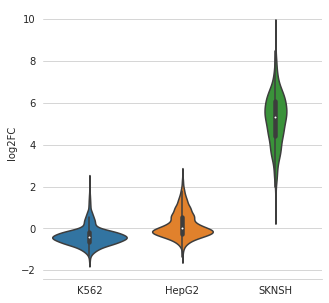

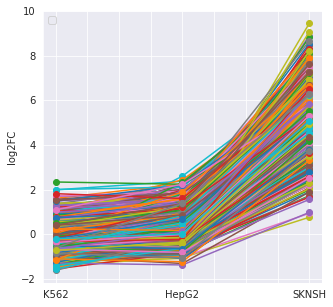

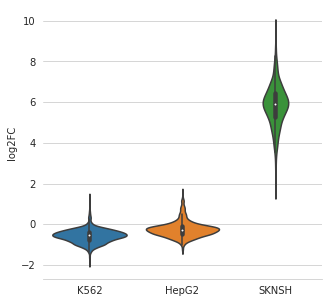

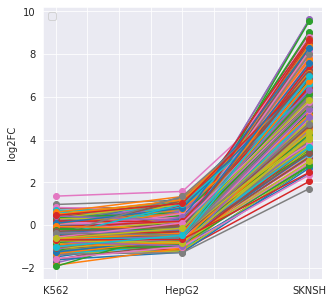

In [32]:
sg_prediction_df = pd.DataFrame(sg_preds, columns=['K562', 'HepG2', "SKNSH"])
rc_prediction_df = pd.DataFrame(rc_preds, columns=['K562', 'HepG2', "SKNSH"])

for prediction_df in [sg_prediction_df, rc_prediction_df]:
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(5,5))
        sns.violinplot(data=prediction_df)
        sns.despine(left=True)
        plt.ylabel('log2FC')
        #plt.ylim(-5,32)
        plt.show()
    with sns.axes_style("darkgrid"):
        prediction_df.T.plot(figsize=(5,5), style='-o')
        #plt.ylim(-5,32)
        plt.legend('')
        plt.ylabel('log2FC')
        plt.show()